#1
We use Metatrader5 API to get historical data for ticker 'F' (Ford ltd). We used monthly data to get higher number of observations, comparing to quaterly data.

code: (Metatrader5 app and library should be installed)
import MetaTrader5 as mt5
import pandas as pd
def random_d_puller2(ticker_):
    if not mt5.initialize():
        print("initialize() failed")
        mt5.shutdown()
    dataset_1=pd.DataFrame(mt5.copy_rates_from(ticker_, mt5.TIMEFRAME_W1, datetime.now(), 90000))
   
    print(len(dataset_1['time']))
    return dataset_1
random_d_puller2('F').to_csv('dataset1w.csv', index=False)

In [28]:
#2
##### visualisation using Candlesticks:
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
dataset=pd.read_csv('dataset1mn.csv')
dataset['timeDecoded']=[datetime.fromtimestamp(dataset['time'][i]) for i in range(len(dataset['time']))]

print('This graph demonstrates how price of Ford ltd stocks have changed over time')
dataset.drop(columns=['tick_volume','spread','real_volume', 'time'], inplace=True)

fig = px.line(dataset, x='timeDecoded', y='close', title='Ford ltd stock "close" prices', labels={
                     "timeDecoded": "Time",
                     "close": "Price",
                 })
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()
print('This graph allows to  observe various components that contribute to the change of Ford ltd stocks over time')
fig = px.line(dataset, x="timeDecoded", y=dataset.columns,
              hover_data={"timeDecoded": "|%B %d, %Y"},
              title='Multivariable data on Ford ltd stocks prices',
              labels={
                     "timeDecoded": "Time"
                 })
fig.update_xaxes(
    rangeslider_visible=True, 
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ))
fig.update_layout(yaxis=dict(title=dict(text="Price")))
fig.show()

##### visualisation using OHLC Chart:
fig = go.Figure(data=go.Ohlc(x=dataset['timeDecoded'],
                    open=dataset['open'],
                    high=dataset['high'],
                    low=dataset['low'],
                    close=dataset['close']))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(title=dict(text="OHLC Chart of Ford ltd stock prices"), yaxis=dict(title=dict(text="Price")), xaxis=dict(title=dict(text="Time")))
fig.show()
##### split of the dataset:
traindata=dataset.iloc[:int(0.8*len(dataset['open'])), :]
testdata=dataset.iloc[int(0.8*len(dataset['open'])):, :]

This graph demonstrates how price of Ford ltd stocks have changed over time


This graph allows to  observe various components that contribute to the change of Ford ltd stocks over time


In [30]:
#3
from statsmodels.tsa.seasonal import seasonal_decompose
##### preparation of the dataset
dataset=pd.read_csv('dataset1mn.csv')
dataset['time'] = pd.to_datetime(dataset['time'], unit='s')
dataset.set_index('time', inplace=True)
time_series = dataset['open']
##### decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
####33 graph setup
plot2=go.Figure()
trendline=go.Scatter(x=dataset.index,y=trend, name='trend')
seasline=go.Scatter(x=dataset.index, y=seasonal, name='seasonality')
residline=go.Scatter(x=dataset.index, y=residual, name='residuals')
plot2.add_trace(trendline)
plot2.add_trace(seasline)
plot2.add_trace(residline)
plot2.show()

In [ ]:
#4
##### prediction using Random forest regressor:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint
import numpy as np
##### function for preparing random batches
def create_dataset3(dataset, step, n, mode):
    X, y = [], []
    unif_ind=randint.rvs(0, int(0.7*len(dataset)-step-n), size=int(0.1*len(dataset)))
    for i in unif_ind:
        X.append(pd.concat([dataset.iloc[i:i+step, 1], dataset.iloc[i:i+step, 2], dataset.iloc[i:i+step, 3]], axis=0))
        y.append(dataset.iloc[i+step:i+step+n, mode])
    return np.array(X), np.ravel(y)
###### random forest regression
def rf_regression():
    X_train, y_train=create_dataset3(dataset=traindata, step=10, n=1, mode=1)
    X_test, y_test=create_dataset3(dataset=testdata, step=10, n=1, mode=1)
    modelRF = RFR(n_estimators=100, random_state=1)
    modelRF.fit(X_train, y_train)
    y_pred=modelRF.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae
error=rf_regression()
print(f'Random forest mean absolute error: {error}')

##### prediction using Gradient boosting regressor:
def gb_regression():
    X_train, y_train=create_dataset3(dataset=traindata, step=10, n=1, mode=1)
    X_test, y_test=create_dataset3(dataset=testdata, step=10, n=1, mode=1)
    modelGB = GBR(n_estimators=100, random_state=1)
    modelGB.fit(X_train, y_train)
    y_pred=modelGB.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae
error=gb_regression()
print(f'Gradient boosting mean absolute error: {error}')

Random forest mean absolute error: 2.43696
Gradient boosting mean absolute error: 1.016112867163379


In [32]:
#5
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def ets_regression():
    dataset=pd.read_csv('dataset1mn.csv')
    dataset['timeDecoded']=[datetime.fromtimestamp(dataset['time'][i]) for i in range(len(dataset['time']))]
    dataset.set_index('timeDecoded', inplace=True)
    traindata = dataset.iloc[:int(0.8 * len(dataset)), :]
    testdata = dataset.iloc[int(0.8 * len(dataset)):, :]

    modelETS = ExponentialSmoothing(traindata['close'], trend="additive", seasonal="additive", seasonal_periods=12)
    fitted_model = modelETS.fit()
    y_pred = fitted_model.predict(start=testdata['close'].index[0], end=testdata.index[-1])
    mae = mean_absolute_error(testdata['close'], y_pred)
    return mae
error=ets_regression()
print(f'ETS regression mean absolute error: {error}')

ETS regression mean absolute error: 6.25151280083764


c:\Users\Дмитрий\OneDrive\Рабочий стол\dataproject\pojvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [33]:
#6   ###### prediction using multilayer perceptron
from sklearn.neural_network import MLPRegressor
dataset=pd.read_csv('dataset1mn.csv')
dataset['time'] = pd.to_datetime(dataset['time'], unit='s')
dataset.set_index('time', inplace=True)
time_series = dataset['open']
decomposition = seasonal_decompose(time_series, model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decompdataset=pd.DataFrame()
decompdataset['trend']=trend
decompdataset['seasonal']=seasonal
decompdataset['residual']=residual
traindata=dataset.iloc[:int(0.8*len(decompdataset['trend'])), :]
testdata=dataset.iloc[int(0.8*len(decompdataset['trend'])):, :]
def mlp_regression():
    tr_pred, tr_targ=create_dataset3(dataset=traindata, step=10, n=1, mode=0)
    ts_pred, ts_targ=create_dataset3(dataset=testdata, step=10, n=1, mode=0)
    layers=(90, 72, 63, 54, 30)
    model=MLPRegressor(random_state=1, max_iter=1000, solver='lbfgs', activation='identity', hidden_layer_sizes=layers).fit(X=tr_pred, y=tr_targ)
    ts_model=model.predict(ts_pred)
    mae=mean_absolute_error(y_true=ts_targ, y_pred=ts_model)
    return mae
error=mlp_regression()
print(error)

0.6226842859061769


In [35]:
from statistics import mean
import warnings
warnings.filterwarnings("ignore")
errors=[[], [],[], []]
###### run code 100 time and take avg of mae
for i in range(100):
    mae1=rf_regression()
    mae2=gb_regression()
    mae3=mlp_regression()
    mae4=ets_regression()
    errors[0].append(mae1)
    errors[1].append(mae2)
    errors[2].append(mae3)
    errors[3].append(mae4)
print(f'RF regressor avg mae: {mean(errors[0])}\n GB regressor avg mae: {mean(errors[1])}\n MLP regressor avg mae: {mean(errors[2])}\n ETS regressor mae: {mean(errors[3])}')

RF regressor avg mae: 1.8322644000000006
 GB regressor avg mae: 1.7953945264846427
 MLP regressor avg mae: 0.7428002966970412
 ETS regressor mae: 6.25151280083764


#7 due to limited number of observations it is impossible to test the model precisely. But if we repeat the procedure of model trainig many times, we see that the multilayer perceptron highest precision of forecast, but that might occure due to specification of the model (only trendline was forecasted). Among RF, GB and ETS models GB has the smallest mean absolute error, RF has close results. ETS model has the greatest mae

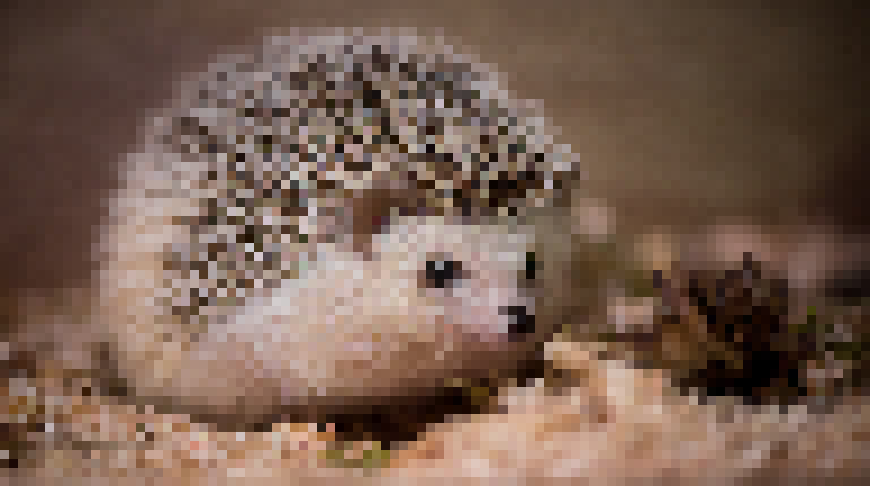

In [36]:
#8
from PIL import Image
import requests
def pixelate(image, pixel_size):

    width, height = image.size
    new_width = width // pixel_size
    new_height = height // pixel_size

    # Resize the image to the new pixelated dimensions
    resized_image = image.resize((new_width, new_height), Image.NEAREST)

    # Upscale the resized image back to the original size
    pixelated_image = resized_image.resize((width, height), Image.NEAREST)

    return pixelated_image

# Load the image
image = Image.open(requests.get('https://img.belta.by/images/storage/news/with_archive/2021/000029_1636971605_469628_big.jpg', stream=True).raw)


# Pixelate the image with a pixel size of 10
pixel_size = 9
pixelated_image = pixelate(image, pixel_size)


pixelated_image


In [38]:
import tkinter as tk

def check_answer():
    global keep_running  # Access the global flag variable
    user_answer = answer_entry.get()
    if user_answer.lower() == "hedgehog":  # Replace with your correct answer
        result_label.config(text="That's right! You win!") 
        keep_running = False  # Set the flag to False to end the loop
        image.show()
    else:
        result_label.config(text="Oops, that's not quite right. Try again.")
        # keep_running = False

# Create the main window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Create the pop-up window
popup = tk.Toplevel(root)
popup.title("Question Time!")

# Question label
question_label = tk.Label(popup, text="Which animal was pixilated?)")
question_label.pack()

# Answer entry
answer_entry = tk.Entry(popup)
answer_entry.pack()

# Check button
check_button = tk.Button(popup, text="Enter", command=check_answer)
check_button.pack()

# Result label (initially empty)
result_label = tk.Label(popup, text="")
result_label.pack()

# # Add a close button (this is not strictly necessary anymore)
# close_button = tk.Button(popup, text="Close", command=popup.destroy)
# close_button.pack()

# Initialize the flag variable
keep_running = True

# Start the main loop
while keep_running:
    try:
        popup.update_idletasks()  # Update the GUI to process events
        popup.update()  # Update the GUI to process events
    except tk.TclError:  # Catch the error when the window is closed
        keep_running = False  # Set the flag to False to end the loop
popup.destroy()  # Close the window after the loop ends

KeyboardInterrupt: 